# Quantum Fourier interpolation

In numerical analysis we quite often have to work with discretized versions of functions, because we do not have any other much simpler exact representation. Note that "function" is a very loose concept: it can be the solution to a differential equation, or a recording of a sound, or an image.

When working with these discretized functions, we often need to find another representation of the same function, using a higher resolution. This is called *interpolation*. [Remember those CSI films](https://www.youtube.com/watch?v=I_8ZH1Ggjk0), with "enhance, zoom, detail!" and how they could pop up the face of any subject out of a very crappy picture?

In this notebook we will develop a strategy for interpolation based on the Fourier transform. This strategy is analogous to the one developed by Nyquist and Shannon, on which is based much of today's sound systems. As you may have guessed, because the quantum computer has an algorithm called the Quantum Fourier Transform, we will be able to do that interpolation with fewer resources than a classical computer.

## Auxiliary code

We load the subsets of numpy and qiskit that we need.

In [1]:
import numpy as np
import numpy.fft
import matplotlib.pyplot as plt
from qiskit.aqua.circuits import StateVectorCircuit
from qiskit.circuit.library import QFT, Barrier
from qiskit import QuantumCircuit, QuantumRegister, execute, Aer

This function takes a vector $f$ and returns $\frac{1}{\sqrt{C}}f,$ where $C=\sum_n |f_n|^2.$

In [2]:
def normalize(ψ):
    n = np.linalg.norm(ψ)
    return ψ if n == 0 else ψ / n

This function takes a quantum circuit and executes it in Qiskit's quantum simulator, recovering  a vector $(f_0,f_1,\ldots)$ with all elements of the wavefunction $U|00\ldots\rangle = \sum_n f_n |n\rangle,$ sorted by all integers $n$ that can be encoded in the quantum register.

In [3]:
def wavefunction(circuit):
    backend = Aer.get_backend('statevector_simulator')
    return execute(circuit.copy(), backend).result().get_statevector()

## Classical Fourier transforms

### a) The Fourier transform

As mentioned above, we work with functions $f(x)$ that have been discretized over a regular grid of equispaced points. We call $\Delta x$ the spacing, $N$ is the number of points and the coordinates of the grid start at $x=a$ and end at $x=b,$ with total length $L=|b-a|$. Mathematically, we write this as follows
$$x_n = a + n\Delta x,\; \Delta x = \frac{|b-a|}{N}=\frac{L}{N},\;0 \leq n < N.$$

Instead of working with the original function, we can work with the vector that contains all its values $\vec{f}=(f(x_0),f(x_1),\ldots,f(x_{N-1})).$ The discrete Fourier transform is an alternative representation, that reconstructs the values of $\vec{f}$ from a combination of trigonometric functions
$$f(x_n) = \frac{1}{\sqrt{N}}\sum_{m=0}^{N-1} \tilde{f}_m e^{i k_m x_n},$$
with momenta (or frequencies)
$$k_m = \frac{2\pi}{L}\times m,\; 0 \leq m < N.$$

The Fourier transform is the mathematical operation that reconstructs the coefficients $\tilde{f}_m$ of this expansion using the values of the discretized function $f_n=f(x_n)$
$$(F\vec{f})_m = \sum_n \frac{1}{\sqrt{N}}e^{-i k_m (x_n-a)} f_n = \sum_n \frac{1}{\sqrt{N}}\exp\left(-i 2\pi \frac{m n}{N}\right) f_n,$$

### b) Allowed momenta

The choice of momenta that we introduced above is mathematically rigorous, but it is a bit inconvenient. From this notation, it would seem that $k_{N-1}$ is the most rapidly oscillating plane wave, but this is not true in the lattice that we have designed.

On the discretized lattice, $k_{N-1}$ produces the same oscillations as $-2\pi/L,$ which is equivalent to $-k_1.$ For this reason, it is convenient to keep in mind that the values $k_m$ can be reinterpreted as a set of positive and negative momenta, given by
$$k_m' \in \left\{0,\ldots,+2\pi\frac{[(N-1)/2]_0}{L},-2\pi\frac{[N/2]_0}{L},\ldots,-2\pi\frac{1}{L}\right\},$$
where $[x]_0$ means truncate the real number $x$ towards zero. This also makes sense because the new basis of wavefunctions, with positive and negative momenta, correspond to the Fourier modes that we would find when expanding $f(x)$ in the infinite domain limit $L\to\infty.$

This reinterpretation has no consequences on the momentum states. Note that we can write
$$k_m = k_m'\,\mathrm{mod}\,\frac{2\pi N}{L}$$
which implies that both intepretation produce the same functions
$$\exp\left(i k_m (x_n-a)\right) = \exp\left[i \left(k_m'+2\pi \frac{z}{\Delta x}\right) n \Delta{x}\right]
= \exp\left(i  k_m' \Delta{x} n+ i 2\pi z\right).$$

## Quantum Fourier transform

### a) Encoding discretized functions in states

If we have a discretized function $f(x_n)$ we can store it in a quantum state, as
$$|f\rangle = \frac{1}{\sqrt{C}} \sum_n f(x_n) |n\rangle. $$
Here $|n\rangle$ is the state of the quantum register that encodes the integer $n \in [0,N-1]$, and $C$ is a normalization factor
$$C = \sum_m |f(x_m)|^2.$$

**Exercise 1**

In Qiskit, there is a class called [`StateVectorCircuit`](https://qiskit.org/documentation/stubs/qiskit.aqua.circuits.StateVectorCircuit.html) that takes a discretized function with $2^l$ components and returns a quantum circuit that implements it. To be more precise, this function constructs a circuit $U$ such that
$$U|00\ldots\rangle = \sum f(q_l 2^{l-1} + \ldots + q_1 2 + q_0) |q_{l-1}\ldots q_1 q_l\rangle.$$
The index $n$ in the lattice is decomposed as a binary number $[q_{l-1}\cdots q_1q_0]$ where the last qubit $q_{l-1}$ is the most significant bit.

The following function returns the circuit for a Gaussian function over a finite interval and plots both the original function, and the one generated by the circuit:

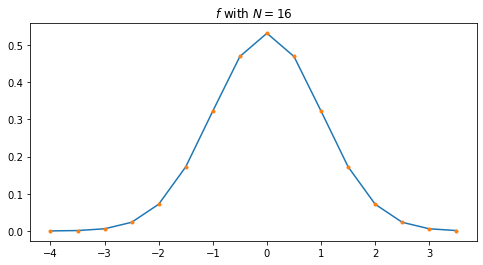

In [4]:
def exercise1():
    
    l = 4 # Number of qubits
    N = 2**l
    L = 8
    Δx = L/N
    x = -L/2 + Δx * np.arange(N)
    #
    # Discretize our function, and normalize it to turn it into a
    # quantum state
    f = normalize(np.exp(-x**2/2.0))
    #
    # Use Qiskit to build a quantum circuit that constructs the
    # quantum state associated to the discretize function 'f'
    f_qc = StateVectorCircuit(f).construct_circuit()
    
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(8,4))
    ax.plot(x, f, '-')
    ax.plot(x, np.abs(wavefunction(f_qc)), '.')
    ax.set_title(f'$f$ with $N={N}$')
    
exercise1()

Print and inspect the complexity of those circuits for other functions and other grid sizes $N$ or $L$.

### b) Quantum Fourier Transform (QFT)

There exists a quantum algorithm that, given an encoded state $|f\rangle,$ creates the encoded state for the Fourier transform $|\tilde{f}\rangle. $

This algorithm is represented by the operator (circuit) F,
$$F|f\rangle = \frac{1}{\sqrt{C}}\sum_{m=0}^{N-1} \tilde{f}_m|m\rangle,$$
with the new coefficients being
$$\tilde{f}_m = \frac{1}{\sqrt{N}} \sum_{n=0}^{N-1} \exp(i2\pi n m /N)f_n.$$

The Qiskit library has a function, called [QFT](https://qiskit.org/documentation/stubs/qiskit.circuit.library.QFT.html) that implements the circuit for a Quantum Fourier Transform.

In [5]:
from qiskit.circuit.library import QFT

QFT(3, insert_barriers=True).draw()

┌───┐               ░              ░       ░    
q_0: ┤ H ├─■──────■──────░──────────────░───────░──X─
     └───┘ │pi/2  │      ░ ┌───┐        ░       ░  │ 
q_1: ──────■──────┼──────░─┤ H ├─■──────░───────░──┼─
                  │pi/4  ░ └───┘ │pi/2  ░ ┌───┐ ░  │ 
q_2: ─────────────■──────░───────■──────░─┤ H ├─░──X─
                         ░              ░ └───┘ ░

The problem with this function is that it is assuming $q_0$ is the most significant bit. We can fix it with our own function:

In [6]:
def fQFT(nqubits, **kwdargs):
    circuit = QuantumCircuit(nqubits)
    return circuit.compose(QFT(nqubits, **kwdargs), qubits=list(reversed(range(0,nqubits))))

In [7]:
fQFT(3).draw()

┌───┐   
q_0: ─────────────■───────────■─────┤ H ├─X─
                  │     ┌───┐ │pi/2 └───┘ │ 
q_1: ──────■──────┼─────┤ H ├─■───────────┼─
     ┌───┐ │pi/2  │pi/4 └───┘             │ 
q_2: ┤ H ├─■──────■───────────────────────X─
     └───┘

This function can also be used to implement the inverse transform

In [8]:
fQFT(3, insert_barriers=True, do_swaps=True, inverse=True).draw()

░ ┌───┐ ░               ░                      
q_0: ─X──░─┤ H ├─░──■────────────░──■───────────────────
      │  ░ └───┘ ░  │-pi/2 ┌───┐ ░  │                   
q_1: ─┼──░───────░──■──────┤ H ├─░──┼───────■───────────
      │  ░       ░         └───┘ ░  │-pi/4  │-pi/2 ┌───┐
q_2: ─X──░───────░───────────────░──■───────■──────┤ H ├
         ░       ░               ░                 └───┘

Note that the final swaps at the end are due to the fact that the Fourier transform exchanges the order of the most significant bits: the most significant bit in the input is $q_0,$ while in the output (prior to the SWAP) it was $q_2.$

**Exercise 2**

Investigate with pen an paper the corrected circuit for the QFT. Verify for 3 qubits that, prior to the final SWAP, it implements the classical discrete Fourier transform,
$$\tilde{f}_n = \frac{1}{2^{N/2}}\sum_m f_m \exp(-2\pi i n m / N),$$
with the identification $N=2^3$ and the encoding of integer numbers using the qubits
$$n = 2^{2} q_2 + 2 q_1 + q_0$$
$$m = 2^{2} q_0 + 2 q_1 + q_2$$

**Exercise 3**

Show, using 3 qubits, that fQFT() and fQFT(inverse=True) produce two transformations that cancel each other.

**Exercise 4**

Use the composition of circuits, to implement the Quantum Fourier Transform of the Gaussian circuit from the previous exercise. Plot the wavefunction of the transformed state $|\tilde{f}\rangle.$ 

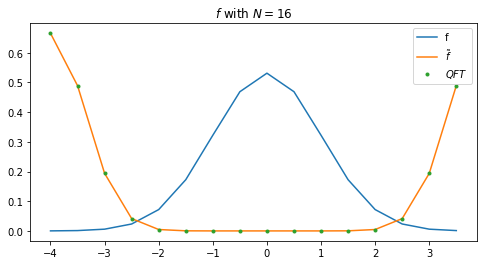

In [9]:
def exercise3():
    l = 4 # Number of qubits
    N = 2**l
    L = 8
    Δx = L/N
    x = -L/2 + Δx * np.arange(N)
    #
    # The original function
    f = normalize(np.exp(-x**2/2.0))
    #
    # Construct the circuit for the function 'f'
    f_qc = StateVectorCircuit(f).construct_circuit()
    #
    # Construct the circuit for the Quantum Fourier Transform
    qft_circuit = QFT(l, do_swaps=True)
    #
    # The QFT acts on the qubits of the circuit in the opposite
    # order than we would like. We explicit this order when
    # we compose the circuits
    qft_order = list(reversed(range(0, l)))
    #
    Ff = f_qc.compose(qft_circuit, qubits=qft_order)
    #
    # We can also compute the classical fourier transform using
    # Python's numpy library
    DFTf = np.fft.fft(f)
    
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(8,4))
    ax.plot(x, f, '-', label='f')
    ax.plot(x, normalize(np.abs(DFTf)), label='$\\tilde{f}$')
    ax.plot(x, np.abs(wavefunction(Ff)), '.', label='$QFT$')
    ax.set_title(f'$f$ with $N={N}$')
    ax.legend()
    
exercise3()

## Fourier Interpolation

Music CD's work because the sound we perceive is bandwidth limited. We only need to store frequencies between 50Hz and 20kHz, which is the range of frequencies the human ear can perceive. Interestingly, when a signal is bandwidth limited, the Nyqist-Shannon interpolation theorem tells us that we can reconstruct the signal with exponential accuracy by sampling it at most at twice the maximum frequency, $2\nu_{max}.$ This recipe is based on an interpolation method that uses the Fourier transform.

Let us assume we have a function $f(x)$ that is sampled at discrete points, with spacing $\Delta{x}.$ We take for granted that this function is bandwidth limited, that is
$$\tilde{f}(k) \simeq 0 \mbox{ for } |k| > k_\max$$

This fact means that if any discretization of $f(x)$ with a grid that satisfies
$$\Delta{x} < \frac{\pi}{k_\max}$$
will have the same information.

In particular, if we compute a discretization of a grid with $N$ points and then with $2N$, the Fourier transforms of both discretization will have the same values within the interval $[-k_\max, k_\max].$ In other words, we have that the Fourier transform $f^{(2N)}$ is obtained by padding with zeros in momentum space. If the original transform was
$$f^{(2N)} = (f^{(N)}_0,\ldots,f^{(N)}_{N-1}),$$
the new one is
$$f^{(2N)} = (f^{(N)}_0,\ldots,f^{(N)}_{(N-1)/2},0,\ldots,0,f^{(N)}_{N/2},\ldots,f^{(N)}_{N-1}).$$
This way of padding is this complicated because the order of the momenta $(k_n)$ does not exactly correspond to how we interpret ($k_n'$ with signs).

**Exercise 5**

Assume that you have constructed $|\tilde{f}^{(N)}\rangle$ with $N=2^2$ points and 2 qubits and want to pad it to work with $2^4$ points and $4$ qubits. Show that the padding with zeros in momentum state can be constructed using control-NOT operations.

In [10]:
aux=QuantumCircuit(4)
aux.cx(1,3)
aux.cx(1,2)
aux.draw()

q_0: ──────────
               
q_1: ──■────■──
       │  ┌─┴─┐
q_2: ──┼──┤ X ├
     ┌─┴─┐└───┘
q_3: ┤ X ├─────
     └───┘

Our Fourier interpolation algorithm works by computing $\tilde{f}^{(N)},$ padding with zeros until it covers $N'=2N,$ and then Fourier transforming back from $\tilde{f}^{(2N)}$ to obtain an estimate for $f^{(2N)}.$ This algorithm also works when $N'=4N, 8N, 16N, $ etc. For instance, the circuit to go from a discretization with 3 qubits to one with 4 would be:

In [11]:
steps = QuantumCircuit(4)
steps.compose(fQFT(3, insert_barriers=True), qubits=[0,1,2], inplace=True)
steps.cx(2,3)
steps.compose(fQFT(4, insert_barriers=True), inplace=True)
steps.draw()

░              ░ ┌───┐ ░                            »
q_0: ─────────────■──────░───────■──────░─┤ H ├─░──X─────────────────────────»
                  │      ░ ┌───┐ │pi/2  ░ └───┘ ░  │                         »
q_1: ──────■──────┼──────░─┤ H ├─■──────░───────░──┼───────────────────■─────»
     ┌───┐ │pi/2  │pi/4  ░ └───┘        ░       ░  │                   │     »
q_2: ┤ H ├─■──────■──────░──────────────░───────░──X───■────────■──────┼─────»
     └───┘               ░              ░       ░    ┌─┴─┐┌───┐ │pi/2  │pi/4 »
q_3: ────────────────────────────────────────────────┤ X ├┤ H ├─■──────■─────»
                                                     └───┘└───┘              »
«             ░                     ░              ░ ┌───┐ ░       
«q_0: ─■──────░──────────────■──────░───────■──────░─┤ H ├─░──X────
«      │      ░              │      ░ ┌───┐ │pi/2  ░ └───┘ ░  │    
«q_1: ─┼──────░───────■──────┼──────░─┤ H ├─■──────░───────░──┼──X─
«      │      ░ ┌───┐ │pi/2  │pi/4  ░ └───┘        ░       ░  │  │ 
«q_2: ─┼──────░─┤ H ├─■──────■──────░──────────────░───────░──┼──X─
«      │pi/8  ░ └───┘               ░              ░       ░  │    
«q_3: ─■──────░─────────────────────░──────────────░───────░──X────
«             ░                     ░              ░       ░

**Exercise 6**

Construct a circuit for a Gaussian using 3 qubits and use the previous algorithm to interpolate it on a grid with $2^4$, $2^5$ and $2^6$ points. Compare the resulting wavefunction with the ideal one and compute the error for different widths of the Gaussian as compared to the size of the discretization interval. Use the following function as guide.

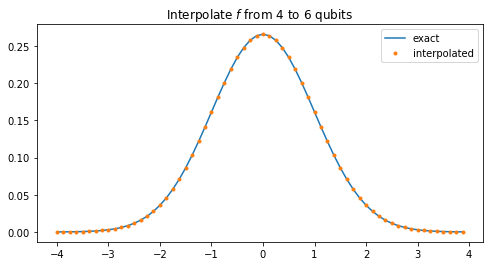

In [13]:
def exercise6():
    l = 4 # Number of input qubits
    N = 2**l
    L = 8
    Δx = L/N
    x = -L/2 + Δx * np.arange(N)
    
    lfinal = l+2 # Number of qubits for interpolation
    xfinal = -L/2 + (Δx/2**(lfinal-l)) * np.arange(2**lfinal)
    #
    # Our circuit (with the final number of qubits)
    steps = QuantumCircuit(lfinal)
    #
    # The original function
    f = normalize(np.exp(-x**2/2.0))
    #
    # The interpolated one
    ffinal = normalize(np.exp(-xfinal**2/2.0))
    #
    # Construct the circuit for the function 'f'
    f_qc = StateVectorCircuit(f).construct_circuit()
    steps.compose(f_qc, qubits=range(0,l), inplace=True)
    #
    # Construct the circuit for the Quantum Fourier Transform
    steps.compose(fQFT(l, insert_barriers=True),
                  qubits=list(range(0, l)), inplace=True)
    #
    # Implement padding
    for i in range(l, lfinal):
        steps.cx(l-1,i)
    #
    # Implement the inverse transform
    steps.compose(fQFT(lfinal, inverse=True, insert_barriers=True),
                  inplace=True)
    #print(steps.draw())
    
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(8,4))
    ax.plot(xfinal, ffinal, '-', label='exact')
    ax.plot(xfinal, np.abs(wavefunction(steps)), '.', label='interpolated')
    ax.set_title(f'Interpolate $f$ from {l} to {lfinal} qubits')
    ax.legend()
    
exercise6()